In [4]:
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(RColorBrewer)
library(tidyr)
library(dplyr)
library(readxl)
library(stringr)

In [5]:
set.seed(1)

In [10]:
load_data <- function(filename) {
    df = read.csv(paste("../data/processed_data/mutations_with_subtypes", 
                        filename, sep="/"))
    return(df)
}

add_sample_to_seurat_proj <- function(proj, matrix_file, barcodes_file, features_file, sample_name) {    
    mat = ReadMtx(mtx = matrix_file, cells=barcodes_file, features=features_file)
    colnames(mat) = paste(sample_name, colnames(mat), sep="#")
    sample_proj = CreateSeuratObject(mat)
    
    if (is.null(proj)) {
        proj = sample_proj
    } else {
        proj = merge(proj, sample_proj)
    }
    return(proj)
}


create_rna_seurat_obj <- function(data_dir) {
    matrix_files <- list.files(data_dir, pattern="matrix", full.names = T)
    features_files <- list.files(data_dir, pattern="features", full.names = T)
    barcodes_files <- list.files(data_dir, pattern="barcodes", full.names = T)
    proj = NULL
    idx = 1
    features_files_search = strsplit(basename(features_files), split = "_")
    features_files_search[[58]] = c("GSM6061702", "CRC1_8810","features.tsv.gz")
    features_files_search[[59]] = c("GSM6061703", "CRC2_15564","features.tsv.gz")
    features_files_search[[60]] = c("GSM6061704", "CRC3_11773","features.tsv.gz")
    features_files_search = unlist(lapply(features_files_search, "[", 2))
    barcodes_files_search = strsplit(basename(barcodes_files), split = "_")
    barcodes_files_search[[58]] = c("GSM6061702", "CRC1_8810","barcodes.tsv.gz")
    barcodes_files_search[[59]] = c("GSM6061703", "CRC2_15564","barcodes.tsv.gz")
    barcodes_files_search[[60]] = c("GSM6061704", "CRC3_11773","barcodes.tsv.gz")
    barcodes_files_search = unlist(lapply(barcodes_files_search, "[", 2))

    for (file in matrix_files) {
        sample_name = unlist(strsplit(basename(file), split="_"))[2]
        print(paste(paste0(idx, "."), "Adding", sample_name))
        barcodes_file = barcodes_files[match(sample_name, barcodes_files_search)]
        features_file = features_files[match(sample_name, features_files_search)]
        proj = add_sample_to_seurat_proj(proj, file, barcodes_file, features_file, sample_name)
        idx = idx + 1
    }
    return(proj)
}

In [ ]:
proj = create_rna_seurat_obj("../data/scRNAseq/greenleaf_colon")

In [8]:
perform_analysis <- function(df, 
                             n_highest_var_feats,
                             pca_n_components,
                             scale,
                             normalize,
                             norm_method,
                             dims_for_dim_reduction,
                             dim_reduction_method,
                             plot_title,
                             color_by,
                             approx_svd,
                             regress_by_counts,
                             seurat_clustering,
                             clustering_res,
                             neighbor_dims,
                             conduct_test,
                             min_mutations_per_sample=0, 
                             save_clustered_mutations=FALSE) {
              
    chr_ranges = colnames(df)[grepl("chr[0-9]", colnames(df))]
        
    mutations_df = df[, grepl("chr[0-9]", colnames(df))]
    mutations_df = t(mutations_df)
    
    colnames(mutations_df) = df[["donor_id"]]
    seurat_data = CreateSeuratObject(counts = mutations_df)
    
    if (!color_by == "mut_counts" && !color_by == "seurat_clusters__categorical") {
        data_color_by = df[[color_by]]
    }
    
    metadata = seurat_data@meta.data
    colnames(metadata)[grepl("nCount_RNA", colnames(metadata))] = "mut_counts"
    seurat_data@meta.data = metadata

    if (color_by != "seurat_clusters__categorical" && color_by != "mut_counts") {
        if (grepl("__categorical", color_by)) {
            seurat_data = AddMetaData(object = seurat_data, metadata = 
                                      data_color_by, col.name = color_by)
        } else {
            seurat_data = AddMetaData(object = seurat_data, metadata = 
                                      as.numeric(data_color_by), 
                                      col.name = color_by)
        }
    }
    
    seurat_data = seurat_data[, seurat_data@meta.data$mut_counts >= min_mutations_per_sample]
    
    if (normalize) {
        seurat_data = NormalizeData(seurat_data, normalization.method=norm_method)
    }

    seurat_data = FindVariableFeatures(seurat_data, nfeatures = n_highest_var_feats)

    if (scale) {
        if (regress_by_counts) {
                seurat_data = ScaleData(seurat_data, verbose=F, vars.to.regress="mut_counts")
        }
        else {
            seurat_data = ScaleData(seurat_data, verbose=F)
        }
    }

    seurat_data = RunPCA(seurat_data, npcs=pca_n_components, verbose=F, approx=approx_svd)
    if (dim_reduction_method == "umap") {
        seurat_data = RunUMAP(object = seurat_data, dims=dims_for_dim_reduction, verbose=F)
    } else if (dim_reduction_method == "tsne") {
        seurat_data = RunTSNE(object = seurat_data, dims=dims_for_dim_reduction, verbose=F)
    }
    settings = paste0("top_", n_highest_var_feats,
                      "-",
                      "scale_", scale,
                      "-",
                      "norm_by_mut_counts_", normalize,
                      "-", 
                      "pca_n_components_", pca_n_components,
                      "-",
                      "dims_for_dim_reduction_", paste0("1to", dims_for_dim_reduction[length(dims_for_dim_reduction)]),
                      "-",
                      "regress_by_counts_", regress_by_counts,
                      "-",
                      "min_mutations_per_sample", min_mutations_per_sample)
    
    if (seurat_clustering) {
        seurat_data = FindNeighbors(seurat_data, dims = neighbor_dims)
        seurat_data = FindClusters(seurat_data, resolution = clustering_res)
        clusters = Idents(seurat_data)
        settings = paste0(settings, "_clustering_res_", clustering_res)
        if (save_clustered_mutations) {
            mutations_df_sep = t(as_tibble(cbind(t(as.data.frame(mutations_df)), clusters, 
                                                 df[["donor_id"]])))
            mutations_df = as_tibble(cbind(t(as.data.frame(mutations_df)), clusters))
            mutations_df = mutations_df %>% 
                                group_by(clusters) %>%
                                summarize(across(everything(), sum)) 
            mutations_df = t(mutations_df)
            mutations_df = as_tibble(mutations_df)[2:nrow(mutations_df), ]
            clusters_names = paste("cluster", seq(from=0, to=ncol(mutations_df)-1), sep="_")
            colnames(mutations_df) = paste(plot_title, settings,
                                           clusters_names, 
                                           sep="x")
            rownames(mutations_df) = chr_ranges
            fn = paste0(settings, ".csv")
            path = paste("../data/processed_data/de_novo_seurat_clustered_mutations", 
                         plot_title, sep="/")
            fp = file.path(path, fn)
            dir.create(path, recursive=T)
            write.csv(mutations_df, fp)
            
            fn_sep = paste0(settings, "_separated.csv")
            fp_sep = file.path(path, fn_sep)
            write.csv(mutations_df_sep, fp_sep)
        }
#         if (conduct_test) {
#             clusters = split(clusters, names(clusters))
#             wilcox.test(group1, group2, alternative = "two.sided", 
#                         conf.int = TRUE)
#         }
    }
    
    seurat_data@meta.data$mut_counts = log(seurat_data@meta.data$mut_counts, base = exp(1))
    
    if (grepl("__categorical", color_by)) {
        print(paste0("Plotting by ", gsub("__categorical", "", color_by)))
        if (color_by == "seurat_clusters__categorical") {
            color_by = "seurat_clusters"
        }
        p = DimPlot(seurat_data, reduction = dim_reduction_method, pt.size=1.5, 
                    group.by = color_by) 
    } 
    else {
        print("Dim Plot")
        p = FeaturePlot(seurat_data, features = color_by, 
                        shape.by=NULL, pt.size=2)
    }

    path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")
    dir.create(path)
    
    filename = paste0(settings,
                      "-",
                      "color_by_", color_by)

    filename = paste0(filename, ".png")

    filepath = paste(path, filename, sep="/")
    ggsave(filepath, plot = last_plot(), dpi = 300, width = 12, height = 8)
    print(p)
}

# Colorectal

In [4]:
df = load_data("colorectal.csv")

In [15]:
colnames(df)[1] = "donor_id"

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 50
Number of edges: 1225

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.1711
Number of communities: 2
Elapsed time: 0 seconds


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message in dir.create(path, recursive = T):
“'../data/processed_data/de_novo_seurat_clustered_mutations/Colorectal' already exists”


[1] "Plotting by __categorical"


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Colorectal' already exists”


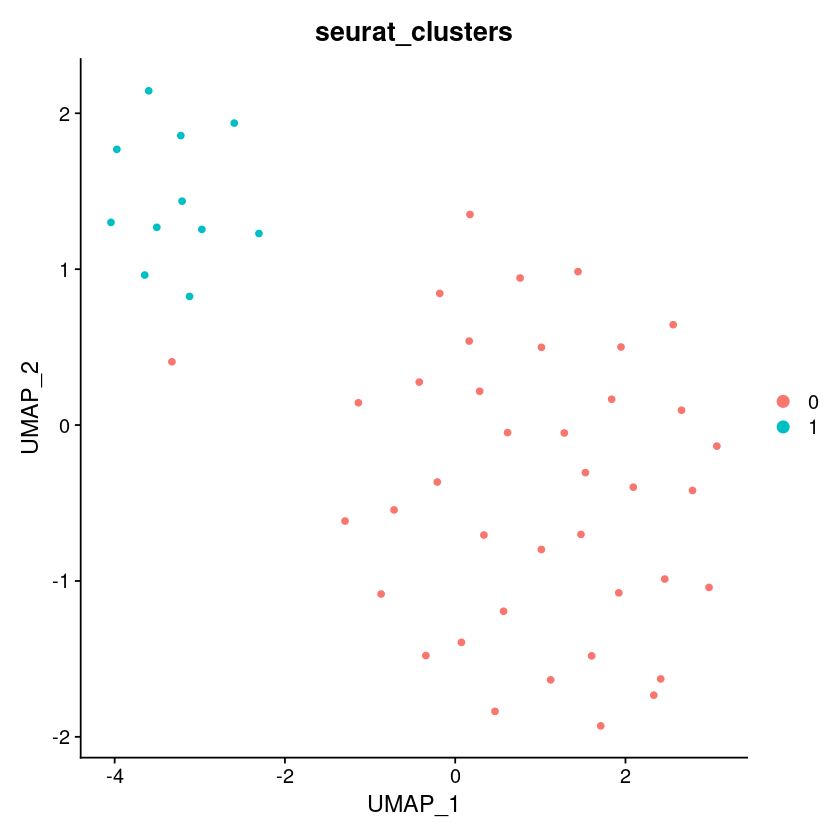

In [24]:
perform_analysis(df, 
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_dim_reduction = 1:15,
                 dim_reduction_method="umap",
                 plot_title = "Colorectal",
                 color_by = "seurat_clusters__categorical",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.83,
                 neighbor_dims = 1:20,
                 conduct_test=F,
                 save_clustered_mutations=T
                )

# Brain

In [5]:
df = load_data("brain.csv")
colnames(df)[1] = "donor_id"
colnames(df)[grepl("subtype", colnames(df))] = "subtype__categorical"
colnames(df)[grepl("provenance", colnames(df))] = "provenance__categorical"
df = df %>% filter(subtype__categorical %in% c("Astrocytoma", "GBM", "Oligo"))
color_by = "subtype__categorical"

In [6]:
n_highest_var_feats = 2000
pca_n_components = 30
scale = T
normalize = T
norm_method = "LogNormalize"
dims_for_dim_reduction = 1:15
dim_reduction_method = "umap"
plot_title = "Brain_3"
color_by = "mut_counts"
regress_by_counts = F
approx_svd=F
seurat_clustering=F
clustering_res=0.7
neighbor_dims = 1:20
conduct_test=F
save_clustered_mutations=F

[1] "Dim Plot"


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Brain_3' already exists”


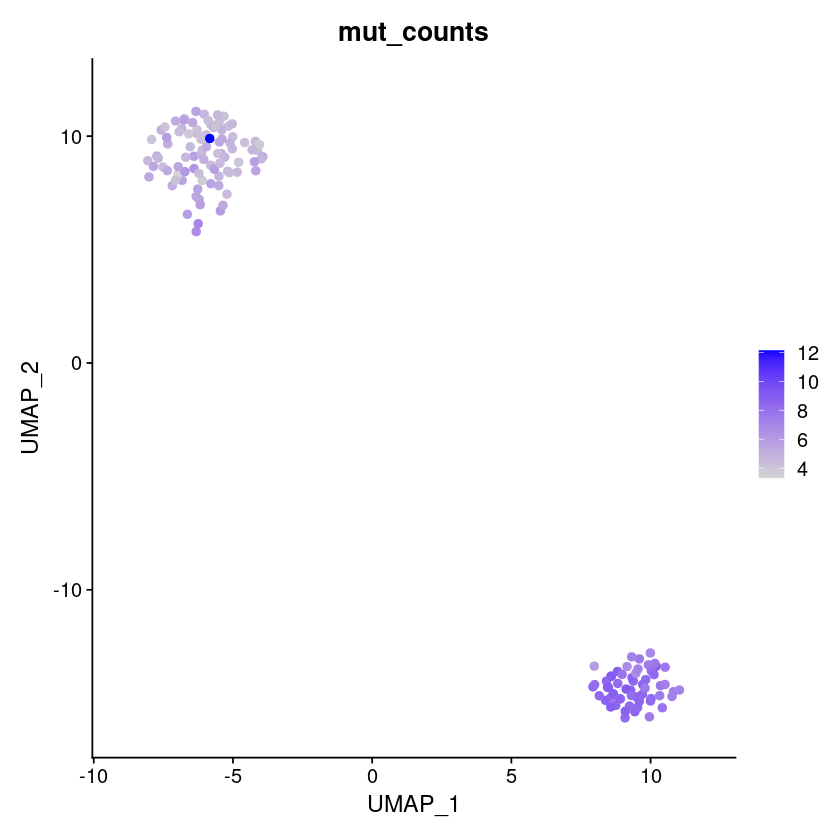

In [9]:
perform_analysis(df, 
                 n_highest_var_feats = 100,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_dim_reduction = 1:15,
                 dim_reduction_method = "umap",
                 plot_title = "Brain_3",
                 color_by = "mut_counts",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 conduct_test=F,
                 save_clustered_mutations=F
                )

In [52]:
mutations_df = df[, grepl("chr[0-9]", colnames(df))]
distance_df = dist(scale(mutations_df, center=T, scale=T), method = "euclidean")
mds_mutations = cmdscale(distance_df, eig=T, x.ret=T)
mds_variance_per_ax = round(mds_mutations$eig / sum(mds_mutations$eig) * 100, 1)
mds_values = mds_mutations$points
mds_data = data.frame(X = mds_values[, 1], Y=mds_values[, 2], subtype = df$subtype)

In [53]:
mds_data = mds_data[mds_data["X"] < 400, ]

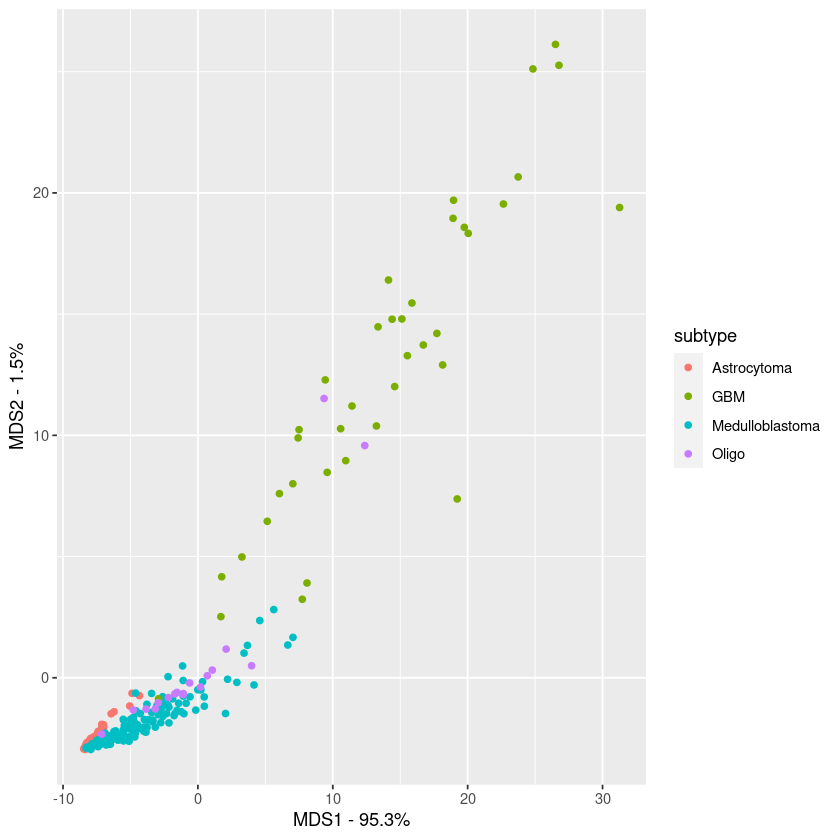

In [54]:
ggplot(data = mds_data, aes(x=X, y=Y, color=subtype)) +
    geom_point() + 
    xlab(paste("MDS1 - ", mds_variance_per_ax[1], "%", sep="")) +
    ylab(paste("MDS2 - ", mds_variance_per_ax[2], "%", sep=""))

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Brain_with_histology' already exists”


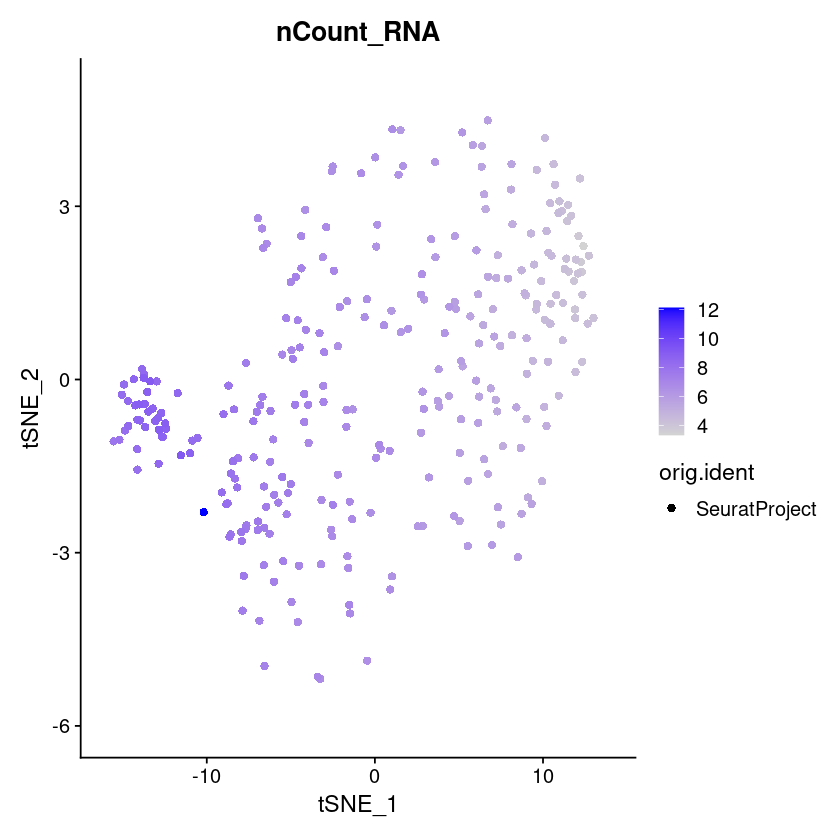

In [55]:
df = load_data("brain_with_histology.csv")
colnames(df)[1] = "donor_id"
df["donor_age_at_diagnosis"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_vital_status"] = ""

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_dim_reduction = 1:15,
                 dim_reduction_method = "tsne",
                 plot_title = "Brain_with_histology",
                 color_by = "mut_counts",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 conduct_test=F,
                 save_clustered_mutations=F
                )

# Lung

In [217]:
df = load_data("all_lung.csv")
colnames(df)[1] = "donor_id"

In [224]:
df = load_data("lung_squamous_adeno.csv")
colnames(df)[1] = "donor_id"

In [225]:
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["provenance"] = ""

In [226]:
df = df[df["subtype"] != "", ]

In [228]:
df["donor_id"] = 1:84

[1] "Plotting by mut_counts"


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Lung_adeno_squamous' already exists”


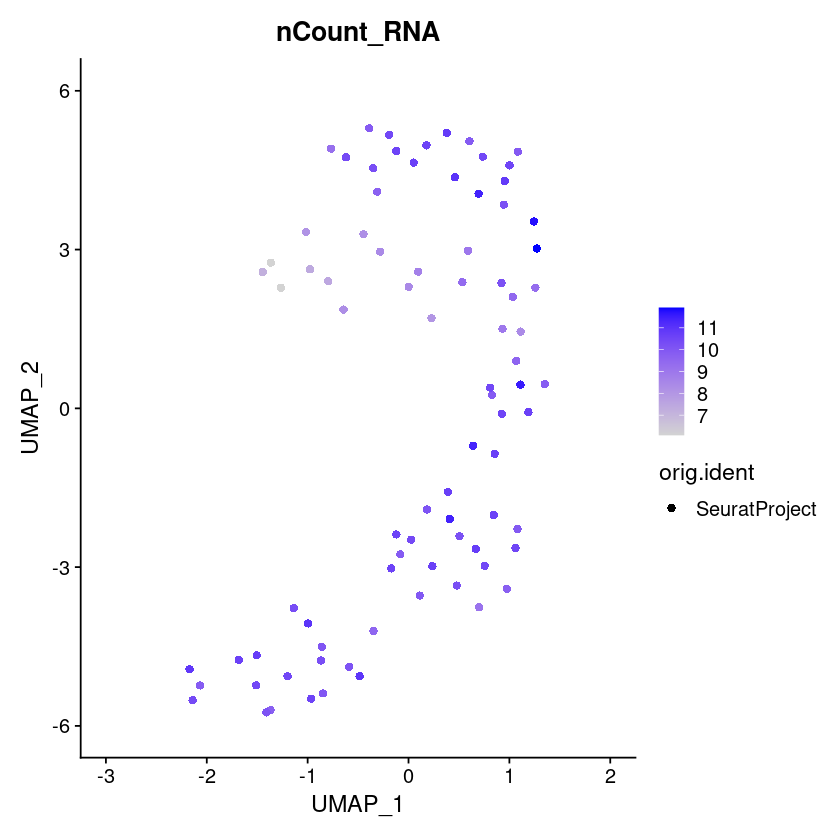

In [231]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dim_reduction_method = "umap",
                 dims_for_dim_reduction = 1:15,
                 plot_title = "Lung_adeno_squamous",
                 color_by = "mut_counts",
                 regress_by_counts=F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims=1:20,
                 conduct_test=F,
                 save_clustered_mutations=F
                )

In [126]:
bottom_n_remove = 0
n_highest_var_feats = 2128
pca_n_components = 30
scale = T
normalize = T
norm_method = "LogNormalize"
dims_for_UMAP = 1:15
plot_title = "Lung"
color_by = "subtype"
regress_by_counts = T
approx_svd=F
seurat_clustering=T
clustering_res=1
neighbor_dims = 1:20
save_clustered_mutations=F

In [71]:
provenance = df["provenance"]
subtypes = df["subtype"]
donor_ids = df["donor_id"]
donor_vital_status = df["donor_vital_status"]
donor_age_at_diagnosis = df["donor_age_at_diagnosis"]
donor_survival_time = df["donor_survival_time"]
donor_interval_of_last_followup = df["donor_interval_of_last_followup"]

In [76]:
chr_ranges = colnames(df)[grepl("chr", colnames(df))]

In [81]:
mutations_df = df[, !(colnames(df) %in% c("provenance", "subtype", "donor_id",
                                          "donor_vital_status", "donor_age_at_diagnosis", 
                                          "donor_survival_time", "donor_interval_of_last_followup"))]


In [83]:
mutations_df = t(mutations_df)

In [85]:
l = drop_low_count_samples(mutations_df, bottom_n_remove, 
                           subtypes, provenance, donor_ids, 
                           donor_vital_status, donor_age_at_diagnosis,
                           donor_survival_time, donor_interval_of_last_followup)


In [88]:
mutations_df = l[[1]]
subtypes = l[[2]]
provenance = l[[3]]
donor_ids = l[[4]]
donor_vital_status = l[[5]]
donor_age_at_diagnosis = l[[6]]
donor_survival_time = l[[7]]
donor_interval_of_last_followup = l[[8]]


In [89]:
colnames(mutations_df) = donor_ids


In [90]:
seurat_data = CreateSeuratObject(counts = mutations_df)


In [95]:
seurat_data = NormalizeData(seurat_data, normalization.method=norm_method)

In [97]:
seurat_data = FindVariableFeatures(seurat_data, nfeatures = n_highest_var_feats)

In [100]:
seurat_data = ScaleData(seurat_data, verbose=F, vars.to.regress="nCount_RNA")

In [103]:
seurat_data = RunPCA(seurat_data, npcs=pca_n_components, verbose=F, approx=approx_svd)
seurat_data = RunUMAP(object = seurat_data, dims=dims_for_UMAP, verbose=F)


In [108]:
seurat_data@meta.data$nCount_RNA = log(seurat_data@meta.data$nCount_RNA, base = exp(1))

In [111]:
p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5) 

In [112]:
path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")

In [ ]:
if (color_by == "mut_counts") {
    p = FeaturePlot(seurat_data, features = "nCount_RNA", shape.by="orig.ident", pt.size=2)
} else if (color_by == "donor_age_at_diagnosis") {
    donor_age_at_diagnosis = as.numeric(donor_age_at_diagnosis)
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_age_at_diagnosis, 
                              col.name = "donor_age_at_diagnosis")
    p = FeaturePlot(seurat_data, features = "donor_age_at_diagnosis", shape.by=NULL, pt.size=2)
} else if (color_by == "donor_survival_time") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_survival_time, 
                              col.name = "donor_survival_time")
    p = FeaturePlot(seurat_data, features = "donor_survival_time", shape.by=NULL, pt.size=2)
} else if (color_by == "donor_interval_of_last_followup") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_survival_time, 
                              col.name = "donor_interval_of_last_followup")
    p = FeaturePlot(seurat_data, features = "donor_interval_of_last_followup", shape.by=NULL, pt.size=2)     
} else if (color_by == "provenance") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              provenance, 
                              col.name = "provenance")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "provenance") 
} else if (color_by == "donor_vital_status") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              donor_survival_time, 
                              col.name = "donor_survival_time")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "donor_survival_time") 
} else if (color_by == "subtype") {
    seurat_data = AddMetaData(object = seurat_data, metadata = 
                              subtypes, 
                              col.name = "subtype")
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5, group.by = "subtype") 
}
else {
    p = DimPlot(seurat_data, reduction = "umap", pt.size=1.5) 
}

path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")
dir.create(path)

filename = paste0(settings,
                  "-",
                  "color_by_", color_by)

filename = paste0(filename, ".png")

filepath = paste(path, filename, sep="/")
ggsave(filepath, plot = last_plot(), dpi = 300, width = 12, height = 8)
print(p)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 37
Number of edges: 666

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.0162
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/lung_adeno' already exists”


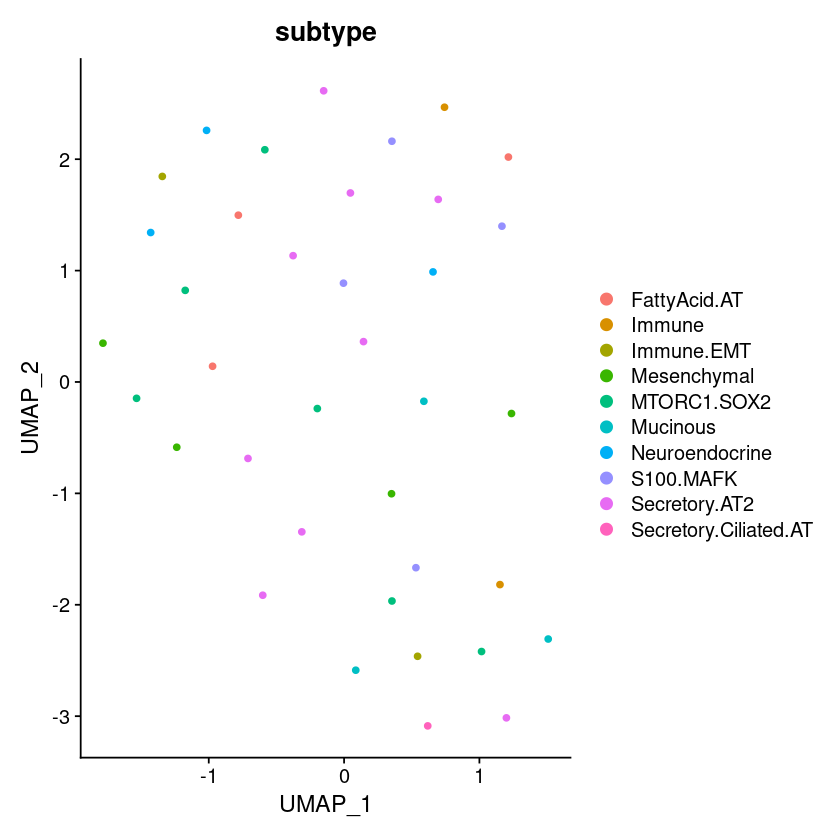

In [119]:
df = load_data("lung_adeno.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 37)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "lung_adeno",
                 color_by = "subtype",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

In [321]:
df = load_data("lung_squamous.csv")

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "lung_squamous",
                 subtype_by_color = T,
                 approx_svd=F
                )

ERROR: Error in perform_analysis(df, bottom_n_remove = 0, n_highest_var_feats = 1000, : unused argument (subtype_by_color = T)


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/lung_meso' already exists”


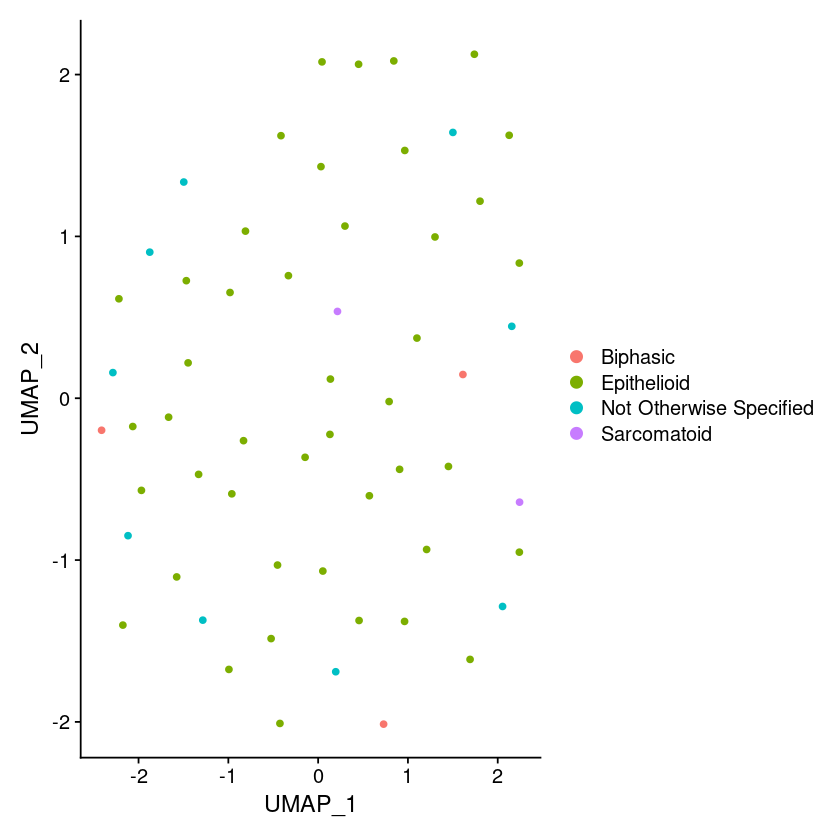

In [6]:
df = load_data("lung_meso.csv")

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize", 
                 dims_for_UMAP = 1:15,
                 plot_title = "lung_meso",
                 subtype_by_color = T,
                 approx_svd=FALSE
                )

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 84
Number of edges: 2434

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3728
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/squamous_subtypes_and_adeno' already exists”


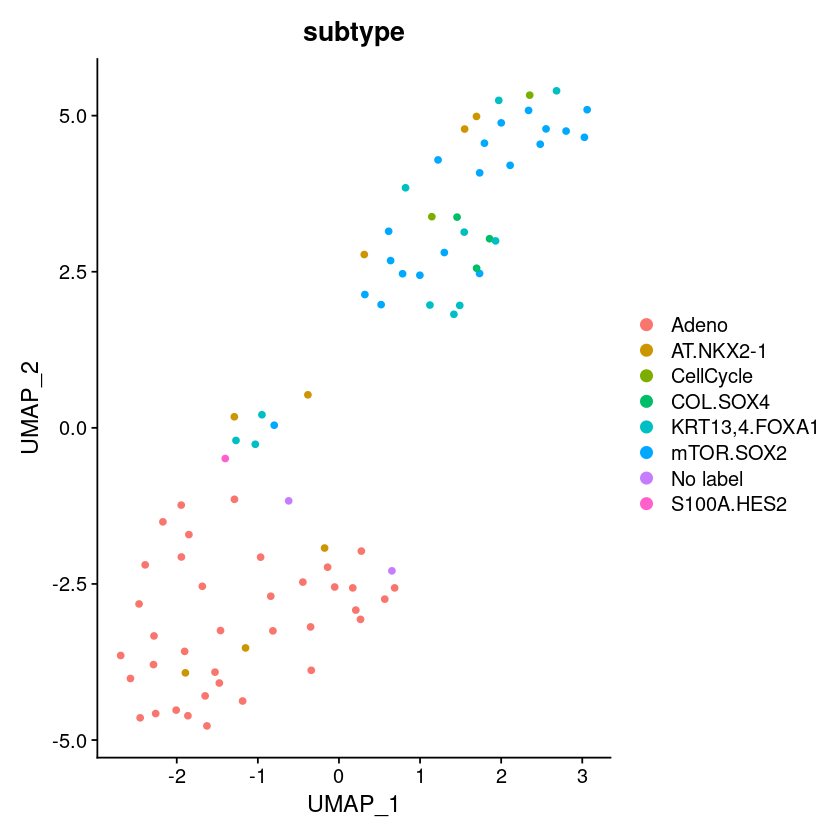

In [121]:
df = load_data("squamous_subtypes_and_lung_adeno.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 84)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "squamous_subtypes_and_adeno",
                 color_by = "subtype",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

In [29]:
sum(df["subtype"] == "mTOR.SOX2")

[1] 20

In [28]:
df = load_data("all_lung.csv")

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "all_lung",
                 subtype_by_color = T,
                 approx_svd=F,
                 regress_by_counts=T
                )

ERROR: Error in perform_analysis(df, bottom_n_remove = 0, n_highest_var_feats = 1000, : unused argument (subtype_by_color = T)


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/SCLC' already exists”


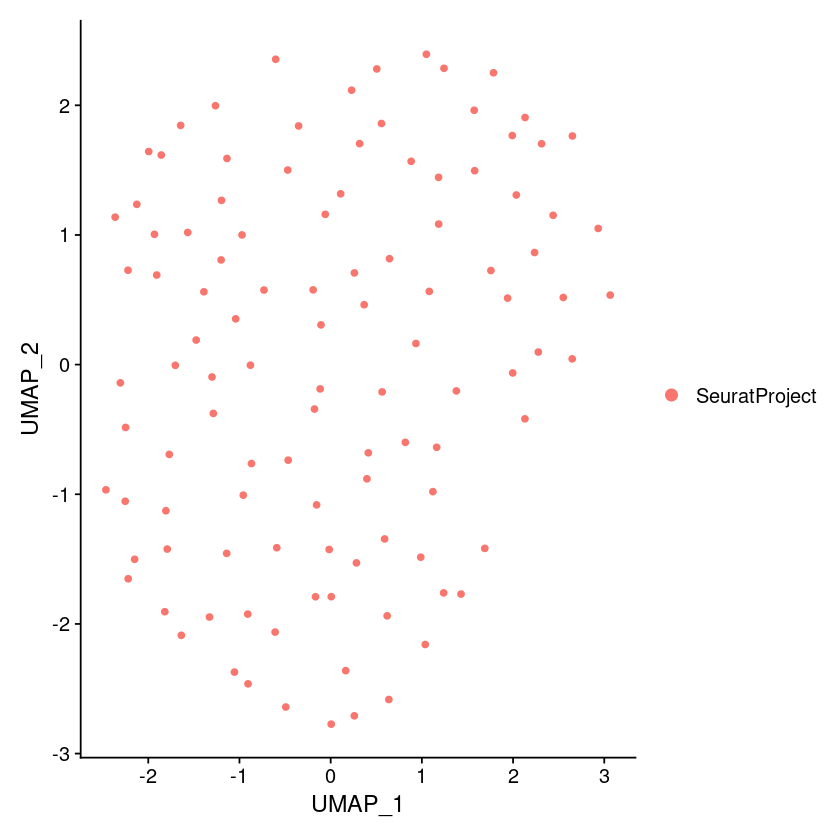

In [135]:
df = load_data("SCLC.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 109)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:20,
                 plot_title = "SCLC",
                 color_by = "seurat",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

# Brain

In [ ]:
df = load_data("brain.csv")

# Medullo

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Medullo' already exists”


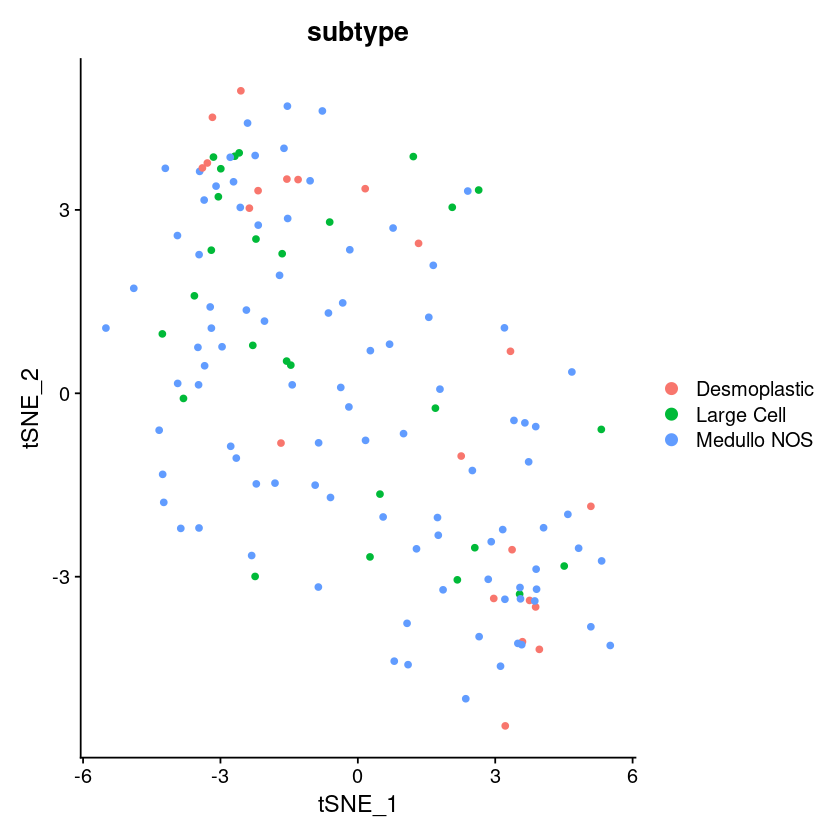

In [66]:
df = load_data("medulloblastoma.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 141)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_dim_reduction = 1:15,
                 dim_reduction_method = "tsne",
                 plot_title = "Medullo",
                 color_by = "subtype",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

# Kidney

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Kidney' already exists”


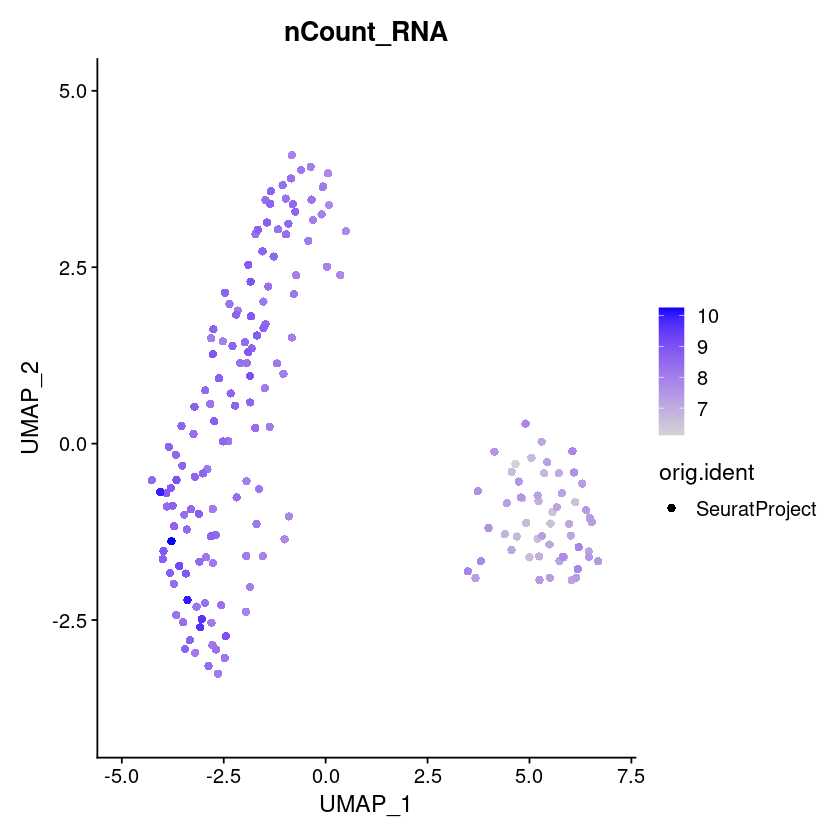

In [61]:
df = load_data("kidney_all.csv")

df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_dim_reduction = 1:15,
                 dim_reduction_method = "umap",
                 plot_title = "Kidney",
                 color_by = "mut_counts",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 conduct_test=F,
                 save_clustered_mutations=F
                )

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32
Number of edges: 496

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3000
Number of communities: 1
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/kidney_papillary' already exists”


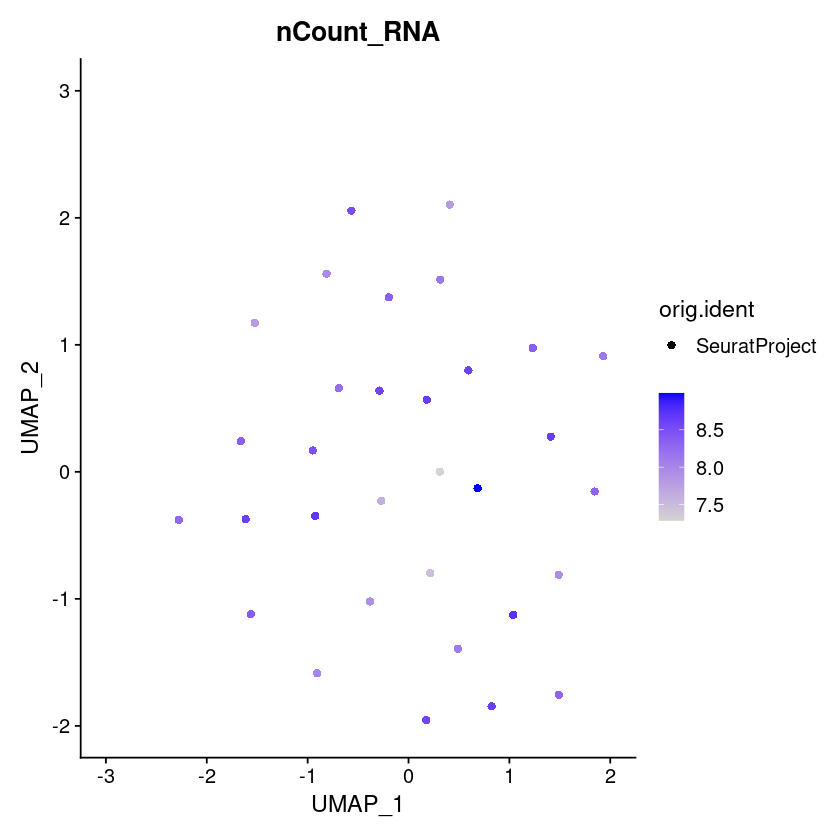

In [50]:
papillary = df[df["subtype"] == "Adenocarcinoma, papillary type", ]

perform_analysis(papillary, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2128,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "kidney_papillary",
                 color_by = "mut_counts",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 conduct_test=F,
                 save_clustered_mutations=F
                )

In [51]:
papillary = t(papillary)

In [52]:
colnames(papillary) = papillary[2,]

In [53]:
papillary = papillary[grepl("chr", rownames(papillary)), ]

In [54]:
colnames(papillary) = paste0("kidney_papillary_", colnames(papillary))

In [55]:
write.csv(papillary, "../data/processed_data/per_patient_mutations/kidney_papillary_per_donor.csv")

# Pancreas

In [273]:
df = load_data("pancreas_all.csv")

In [274]:
df = df[!df[["subtype"]] == "Adenocarcinoma", ]

[1] "Plotting by mut_counts"


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Pancreas' already exists”


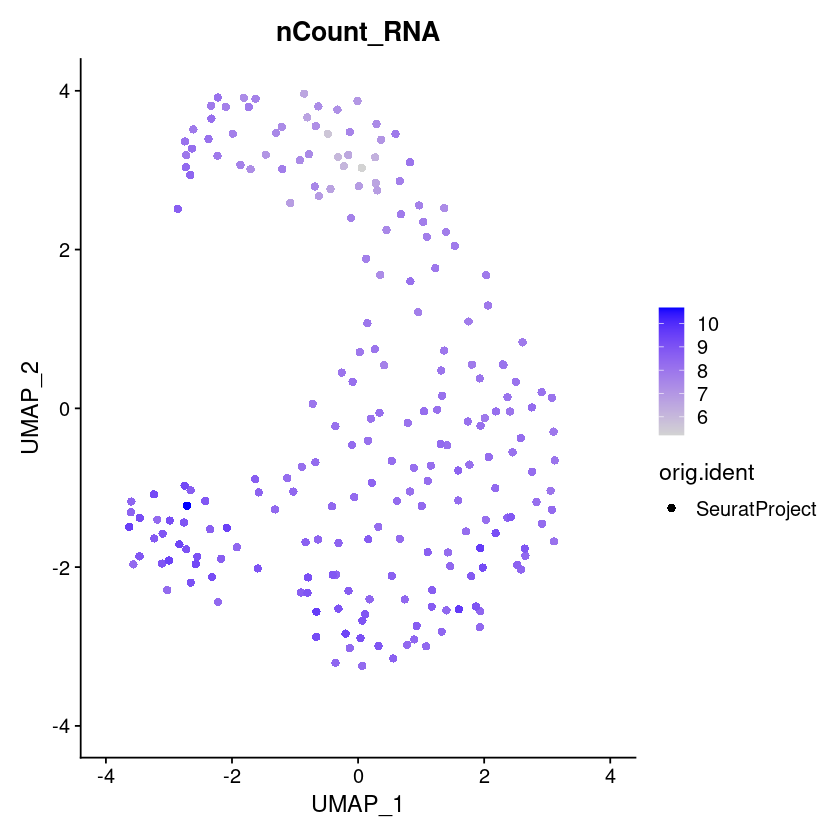

In [281]:
df["provenance"] = ""
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""
df["donor_id"] = seq(1, 219)

perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_dim_reduction = 1:15,
                 dim_reduction_method = "umap",
                 plot_title = "Pancreas",
                 color_by = "mut_counts",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F
                )

In [279]:
pancreas_adeno_only = df[!(df["subtype"] == "Neoroendocrine carcinoma"), ]

[1] "Plotting by mut_counts"


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Pancreas_Adeno' already exists”


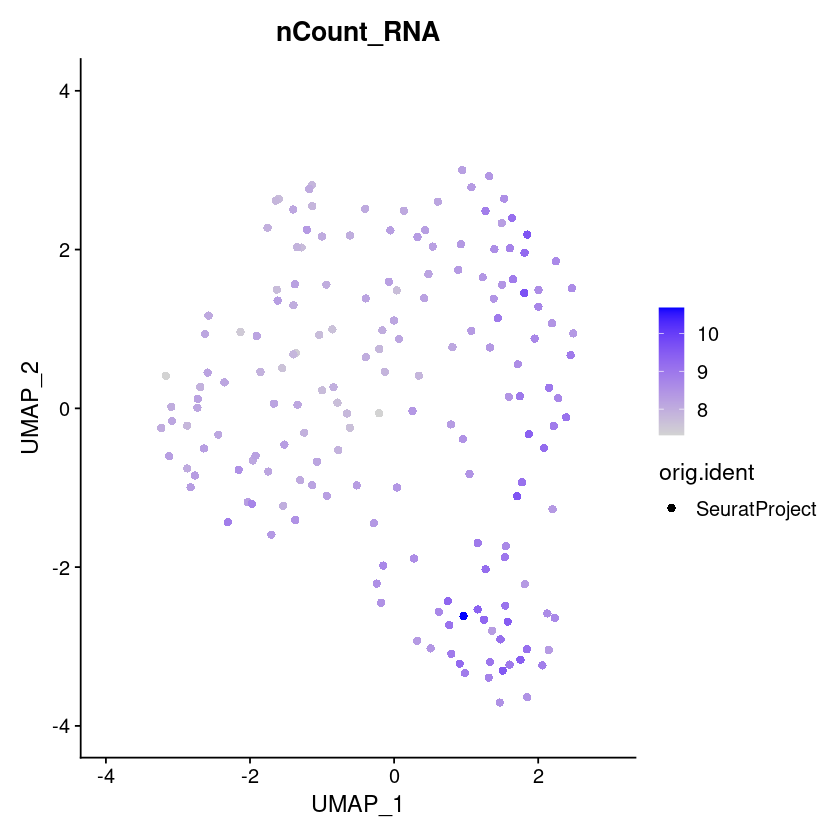

In [282]:
perform_analysis(pancreas_adeno_only, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_dim_reduction = 1:15,
                 dim_reduction_method = "umap",
                 plot_title = "Pancreas_Adeno",
                 color_by = "mut_counts",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.7,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

In [105]:
df_with_cluster_assign = t(as.data.frame(mutations_df))

In [106]:
clusters = data.frame(clusters)

In [107]:
df_with_cluster_assign = merge(df_with_cluster_assign, clusters, by = "row.names")

In [111]:
df_with_cluster_assign = df_with_cluster_assign[2:ncol(df_with_cluster_assign)]

In [112]:
a = split(df_with_cluster_assign, df_with_cluster_assign["clusters"])

In [113]:
a = lapply(a, "[", 1:ncol(a[[1]])-1)

In [121]:
a = lapply(a, colSums)

In [124]:
a = do.call(cbind, a)

In [128]:
colnames(a) = c("panc_adeno_cluster_0", "panc_adeno_cluster_1")

In [129]:
write.csv(a, "de_novo_clustered_panc_adeno_mutations.csv")

In [170]:
df = load_data("pancreas_neuroendocrine.csv")

In [171]:
clinical_data = read_excel("../data/pcawg_donor_clinical_August2016_v9.xlsx")

In [172]:
donors = df[["donor_id"]]

In [173]:
neuroendo_clinical_data = clinical_data[clinical_data[["icgc_donor_id"]] %in% donors, ]

In [174]:
neuroendo_clinical_data = neuroendo_clinical_data[c("donor_vital_status", "donor_age_at_diagnosis", 
                          "donor_survival_time", "donor_interval_of_last_followup",
                          "icgc_donor_id")]

In [175]:
colnames(neuroendo_clinical_data) = c("donor_vital_status", "donor_age_at_diagnosis", 
                                      "donor_survival_time", "donor_interval_of_last_followup",
                                      "donor_id")

In [176]:
df = merge(df, neuroendo_clinical_data)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 81
Number of edges: 2110

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3011
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message in dir.create(path, recursive = T):
“'../data/processed_data/de_novo_seurat_clustered_mutations/panc_neuroendocrine' already exists”
Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/panc_neuroendocrine' already exists”


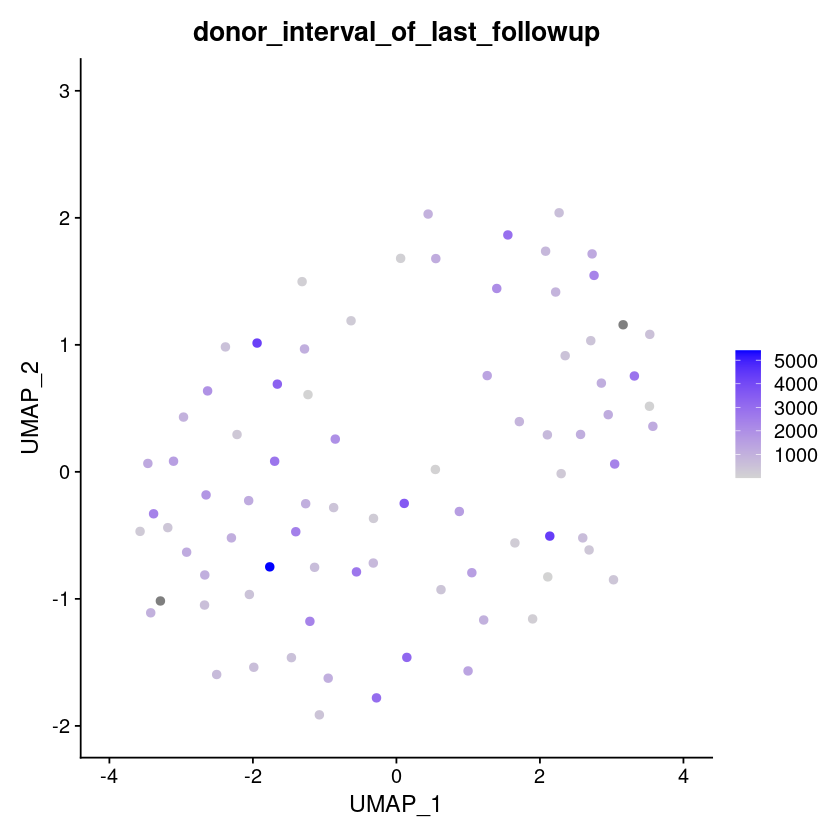

In [199]:
perform_analysis(df,
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "panc_neuroendocrine",
                 color_by = "donor_interval_of_last_followup",
                 regress_by_counts = F,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=T)

In [185]:
df_with_de_novo_clusters = read.csv("../data/processed_data/de_novo_seurat_clustered_mutations/panc_neuroendocrine/top_2000-no_bottom_0_samples-scale_TRUE-norm_by_mut_counts_TRUE-pca_n_components_30-dims_for_UMAP_1:15-regress_by_counts_TRUE_clustering_res_1.csv")

In [186]:
colnames(df_with_de_novo_clusters) = c("chr", "cluster_0", "cluster_1")

In [187]:
df_with_de_novo_clusters = as_tibble(df_with_de_novo_clusters)

In [188]:
df_with_de_novo_clusters = pivot_longer(df_with_de_novo_clusters, cols = c("cluster_0", "cluster_1"))

In [189]:
colnames(df_with_de_novo_clusters) = c("chr", "cluster", "num_mutations")

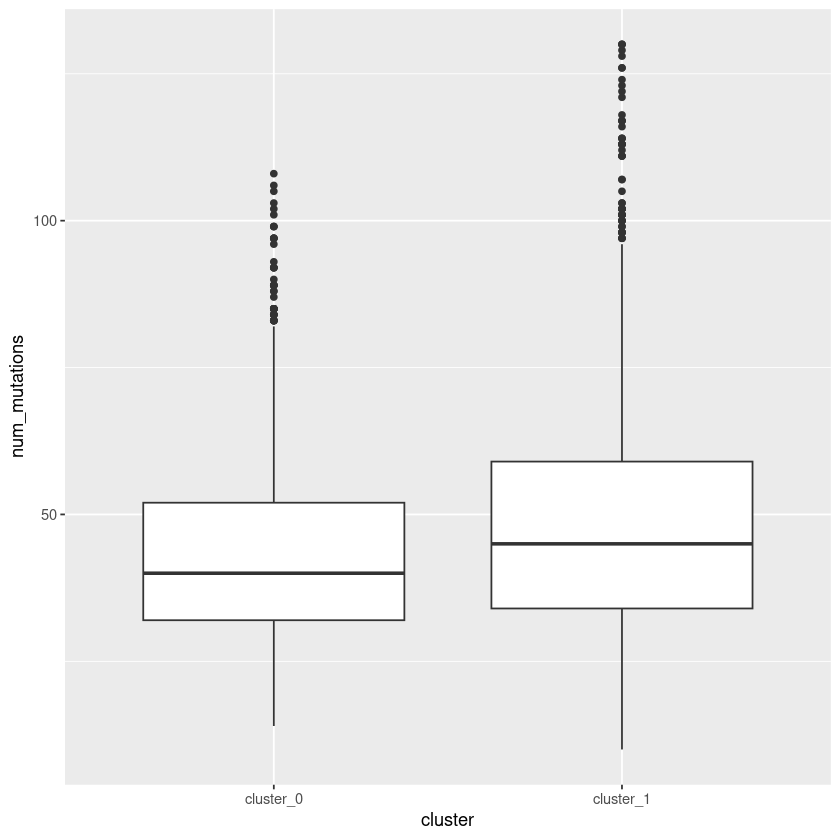

In [190]:
ggplot(df_with_de_novo_clusters, aes(cluster, num_mutations)) +
    geom_boxplot()

In [ ]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Panc Neuroendocrine",
                 plot_type = "color_subtypes",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.9,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 81
Number of edges: 2954

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.1774
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/SCLC' already exists”


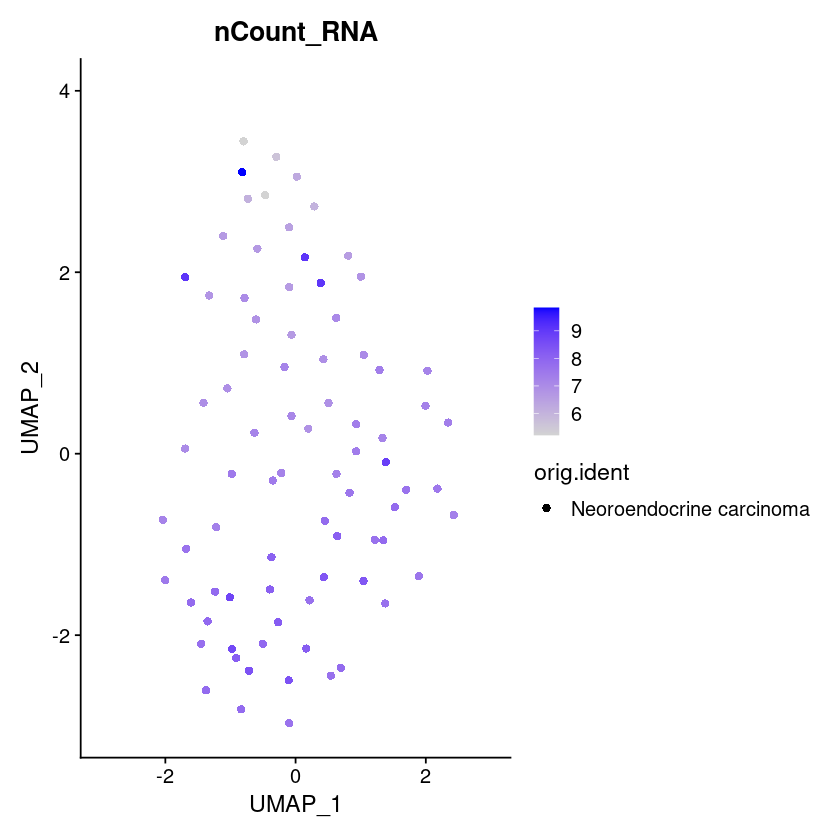

In [25]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Panc Neuroendocrine",
                 plot_type = "mut_count_diff",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.9,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/Panc Neuroendocrine' already exists”


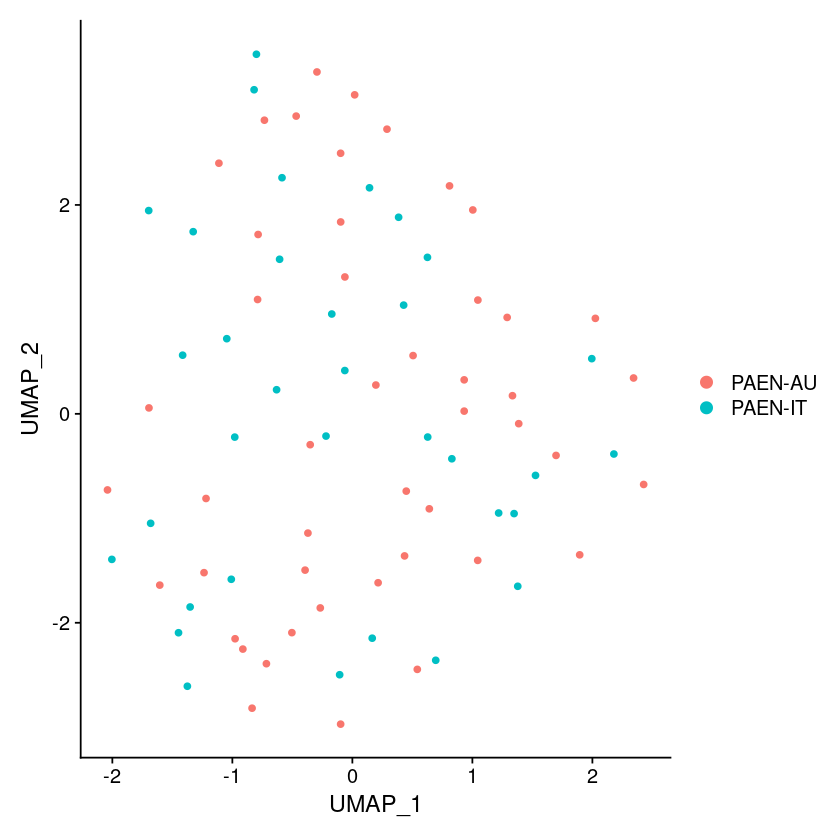

In [70]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 2000,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "Panc Neuroendocrine",
                 plot_type = "color_provenance",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.9,
                 neighbor_dims = 1:20,
                 save_clustered_mutations=F)

# CPTAC

In [77]:
df = readRDS("../data/CPTAC/snp_1MB_profile_lung_CPTAC_3.RDS")
df = t(df)
colnames(df) = df[1, ]
df = as.data.frame(df[2:nrow(df), ])
df[] = lapply(df, as.numeric)
df["donor_id"] = unlist(lapply(strsplit(rownames(df), "__"), "[", 1))
df = df %>% 
        group_by(donor_id) %>%
        summarize(across(everything(), sum))

clinical_df = read.csv("../data/CPTAC/clinical_CPTAC3_available.tsv", sep="\t")
squamous_subtype = read.csv("../data/CPTAC/cptac.lusc.subtypes.csv")

squamous_subtype = as_tibble(squamous_subtype) %>% 
                        filter(!grepl(".N", X)) %>%
                        mutate(X = str_replace(X, "\\.", "-"))

colnames(squamous_subtype) = c("donor_id", "subtype")
case_id_to_case_submitted_id = clinical_df[, c("case_id", "case_submitter_id")]

df$donor_id = case_id_to_case_submitted_id[match(df$donor_id, case_id_to_case_submitted_id$case_id), 
                            "case_submitter_id"]

df = inner_join(df, squamous_subtype)

Joining with `by = join_by(donor_id)`


In [78]:
chr_keep = read.csv("../data/processed_data/chr_keep.csv")

In [79]:
df = df %>% select(c("donor_id", "subtype"), chr_keep[["chr"]])

In [80]:
df = as.data.frame(df)

In [81]:
df["provenance"] = "CPTAC"
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""

In [82]:
df_TCGA_squamous = load_data("lung_squamous.csv")

In [83]:
df_TCGA_squamous["provenance"] = "TCGA"
df_TCGA_squamous["donor_vital_status"] = ""
df_TCGA_squamous["donor_age_at_diagnosis"] = ""
df_TCGA_squamous["donor_survival_time"] = ""
df_TCGA_squamous["donor_interval_of_last_followup"] = ""

In [84]:
df = rbind(df_TCGA_squamous,df)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 101
Number of edges: 3719

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2559
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message in dir.create(path, recursive = T):
“'../data/processed_data/de_novo_seurat_clustered_mutations/combined_TCGA_CPTAC_squamous' already exists”
Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/combined_TCGA_CPTAC_squamous' already exists”


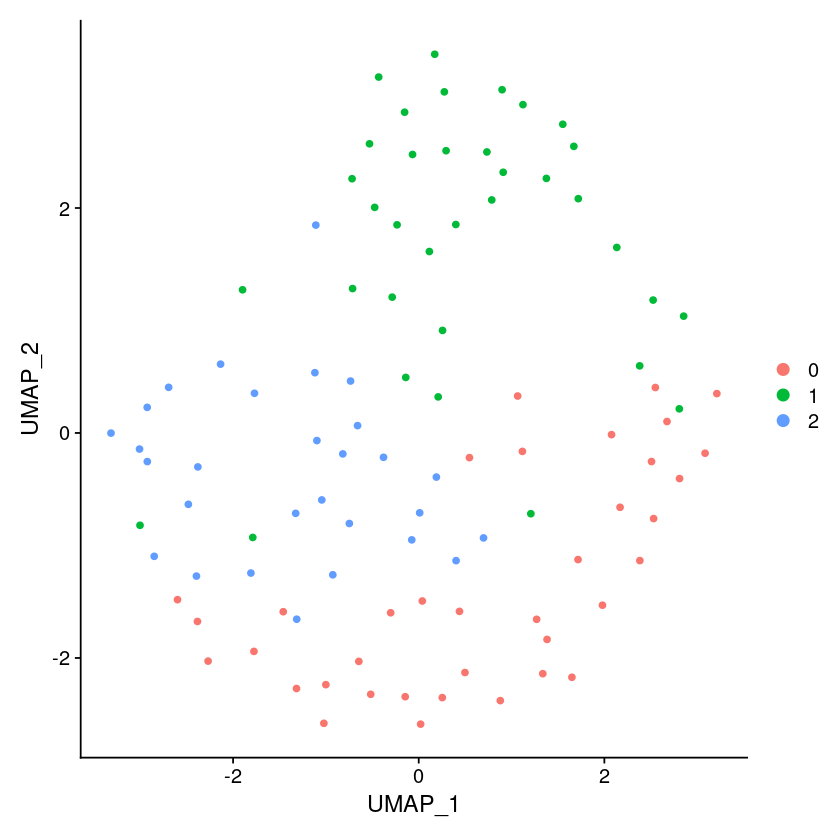

In [105]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1500,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "combined_TCGA_CPTAC_squamous",
                 color_by = "s",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=1,
                 neighbor_dims = 1:20,
                 conduct_test=F,
                 save_clustered_mutations=T)

In [74]:
df = readRDS("../data/CPTAC/snp_1MB_profile_lung_CPTAC_3.RDS")
df = t(df)
colnames(df) = df[1, ]
df = as.data.frame(df[2:nrow(df), ])
df[] = lapply(df, as.numeric)
df["donor_id"] = unlist(lapply(strsplit(rownames(df), "__"), "[", 1))
df = df %>% 
        group_by(donor_id) %>%
        summarize(across(everything(), sum))

clinical_df = read.csv("../data/CPTAC/clinical_CPTAC3_available.tsv", sep="\t")
adeno_subtype = read.csv("../data/CPTAC/cptac.luad.labels.csv")

adeno_subtype = as_tibble(adeno_subtype) %>% 
                        filter(!grepl(".N", X)) %>%
                        mutate(X = str_replace(X, "\\.", "-"))

colnames(adeno_subtype) = c("donor_id", "subtype")
case_id_to_case_submitted_id = clinical_df[, c("case_id", "case_submitter_id")]

df$donor_id = case_id_to_case_submitted_id[match(df$donor_id, case_id_to_case_submitted_id$case_id), 
                            "case_submitter_id"]

df = inner_join(df, adeno_subtype)

Joining with `by = join_by(donor_id)`


In [75]:
chr_keep = read.csv("../data/processed_data/chr_keep.csv")
df = df %>% select(c("donor_id", "subtype"), chr_keep[["chr"]])
df = as.data.frame(df)

df["provenance"] = "CPTAC"
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""

In [76]:
df_TCGA_adeno = load_data("lung_adeno.csv")

In [68]:
colnames(df_TCGA_adeno)[1] = "subtype"

In [69]:
df_TCGA_adeno["provenance"] = "TCGA"
df_TCGA_adeno["donor_vital_status"] = ""
df_TCGA_adeno["donor_age_at_diagnosis"] = ""
df_TCGA_adeno["donor_survival_time"] = ""
df_TCGA_adeno["donor_interval_of_last_followup"] = ""

In [70]:
df = rbind(df_TCGA_adeno, df)

In [71]:
df

subtype,donor_id,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,⋯,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137,provenance,donor_vital_status,donor_age_at_diagnosis,donor_survival_time,donor_interval_of_last_followup
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
FattyAcid.AT,DO25010,27,17,12,22,3,11,24,8,⋯,8,14,7,12,9,TCGA,,,,
MTORC1.SOX2,DO24307,7,7,6,3,1,5,6,3,⋯,6,4,5,6,1,TCGA,,,,
Secretory.AT2,DO23744,29,35,14,19,6,5,14,15,⋯,10,11,7,21,11,TCGA,,,,
S100.MAFK,DO23838,12,12,3,10,3,1,3,6,⋯,6,3,8,14,6,TCGA,,,,
Mesenchymal,DO23735,3,2,1,3,1,0,1,4,⋯,1,1,3,1,1,TCGA,,,,
S100.MAFK,DO25189,145,115,56,68,39,37,65,31,⋯,54,71,45,76,47,TCGA,,,,
Secretory.AT2,DO26062,6,0,3,4,0,1,1,1,⋯,1,3,0,3,1,TCGA,,,,
Neuroendocrine,DO25104,50,34,16,16,8,12,15,18,⋯,14,9,10,16,8,TCGA,,,,
Neuroendocrine,DO24675,28,22,13,11,2,11,8,6,⋯,3,14,5,22,7,TCGA,,,,


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 71
Number of edges: 1827

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3205
Number of communities: 2
Elapsed time: 0 seconds


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/combined_TCGA_CPTAC_adeno' already exists”


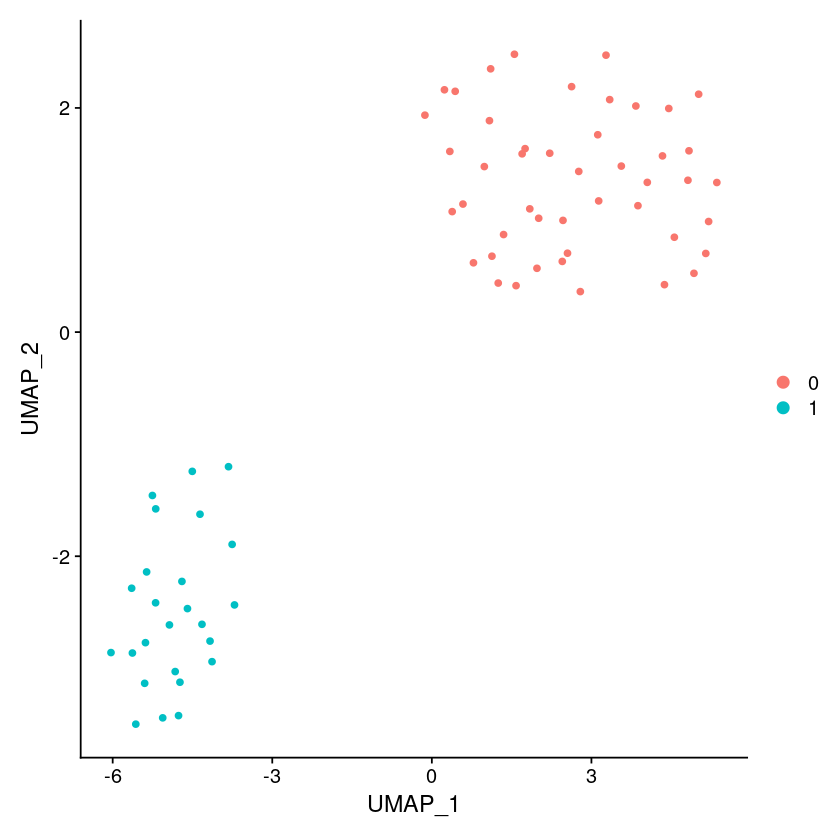

In [73]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1500,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "combined_TCGA_CPTAC_adeno",
                 color_by = "seur",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=T,
                 clustering_res=0.8,
                 neighbor_dims = 1:20,
                 conduct_test = F,
                 save_clustered_mutations=F)

# Pancreas

In [230]:
df = readRDS("../data/CPTAC/snp_1MB_profile_pancreas_CPTAC_3.RDS")
df = t(df)
colnames(df) = df[1, ]
df = as.data.frame(df[2:nrow(df), ])
df[] = lapply(df, as.numeric)
df["donor_id"] = unlist(lapply(strsplit(rownames(df), "__"), "[", 1))
df = df %>% 
        group_by(donor_id) %>%
        summarize(across(everything(), sum))

clinical_df = read.csv("../data/CPTAC/clinical_CPTAC3_available.tsv", sep="\t")
pancreas_subtype = read.csv("../data/CPTAC/pancreatic_cptac_annotation.csv", sep="\t")
pancreas_subtype = pancreas_subtype[, c(1,3)]
colnames(pancreas_subtype) = c("donor_id", "subtype")
pancreas_subtype["donor_id"] = unlist(lapply(strsplit(pancreas_subtype[["donor_id"]], "__"),
                                             "[", 1))
pancreas_subtype = unique(pancreas_subtype)
df = inner_join(df, pancreas_subtype)

Joining with `by = join_by(donor_id)`


In [231]:
chr_keep = read.csv("../data/processed_data/chr_keep.csv")
df = df %>% select(c("donor_id", "subtype"), chr_keep[["chr"]])
df = as.data.frame(df)
df["provenance"] = "CPTAC"
df["donor_vital_status"] = ""
df["donor_age_at_diagnosis"] = ""
df["donor_survival_time"] = ""
df["donor_interval_of_last_followup"] = ""

df_TCGA_panc_adeno = load_data("pancreas_all.csv")
colnames(df_TCGA_panc_adeno)[1] = "subtype"
df_TCGA_panc_adeno["provenance"] = "TCGA"
df_TCGA_panc_adeno["donor_vital_status"] = ""
df_TCGA_panc_adeno["donor_age_at_diagnosis"] = ""
df_TCGA_panc_adeno["donor_survival_time"] = ""
df_TCGA_panc_adeno["donor_interval_of_last_followup"] = ""

df = rbind(df_TCGA_panc_adeno, df)

In [232]:
table(df["subtype"])

subtype
                                                               Acinar 
                                 2                                 37 
             Acinar cell carcinoma                     Adenocarcinoma 
                                 1                                 60 
          Adenocarcinoma, mucinous           Carcinoma, adenosquamous 
                                 4                                  4 
                         Endocrine                         Fibroblast 
                                17                                 14 
                            Immune Invasive carcinoma arising in IPMN 
                                17                                  6 
          Neoroendocrine carcinoma        Pancreatic ductal carcinoma 
                                47                                155 
             Pancreatic_Progenitor                           Squamous 
                                29                                 31

In [233]:
df[df["subtype"] == "Acinar", ]["subtype"] = "Acinar cell carcinoma"

In [234]:
df[df["subtype"] == "Squamous", ]["subtype"] = "Carcinoma, adenosquamous"

In [235]:
df[df["subtype"] == "Endocrine", ]["subtype"] = "Neoroendocrine carcinoma"

In [236]:
table(df["subtype"])

subtype
                                                Acinar cell carcinoma 
                                 2                                 38 
                    Adenocarcinoma           Adenocarcinoma, mucinous 
                                60                                  4 
          Carcinoma, adenosquamous                         Fibroblast 
                                35                                 14 
                            Immune Invasive carcinoma arising in IPMN 
                                17                                  6 
          Neoroendocrine carcinoma        Pancreatic ductal carcinoma 
                                64                                155 
             Pancreatic_Progenitor 
                                29 

In [237]:
df

subtype,donor_id,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,⋯,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137,provenance,donor_vital_status,donor_age_at_diagnosis,donor_survival_time,donor_interval_of_last_followup
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
Pancreatic ductal carcinoma,DO32900,0,2,1,1,0,2,1,4,⋯,3,2,6,3,4,TCGA,,,,
Pancreatic ductal carcinoma,DO34793,2,4,1,1,2,3,3,3,⋯,3,0,1,0,0,TCGA,,,,
"Carcinoma, adenosquamous",DO33368,12,9,1,4,2,0,6,2,⋯,2,2,6,2,2,TCGA,,,,
Pancreatic ductal carcinoma,DO49183,2,3,1,3,0,0,1,1,⋯,1,2,1,0,0,TCGA,,,,
Invasive carcinoma arising in IPMN,DO49137,5,3,1,3,0,1,0,3,⋯,2,0,0,1,3,TCGA,,,,
Pancreatic ductal carcinoma,DO34264,4,1,0,1,1,1,2,0,⋯,1,0,4,0,1,TCGA,,,,
Pancreatic ductal carcinoma,DO33264,2,2,2,2,1,1,3,4,⋯,0,1,1,7,0,TCGA,,,,
Pancreatic ductal carcinoma,DO33960,2,3,2,3,0,2,2,2,⋯,1,1,0,0,0,TCGA,,,,
Pancreatic ductal carcinoma,DO32916,4,8,3,3,3,2,5,8,⋯,4,2,1,5,1,TCGA,,,,


Warning message in dir.create(path):
“'../figures/dim_reduced_data/Seurat/combined_TCGA_CPTAC_pancreas' already exists”


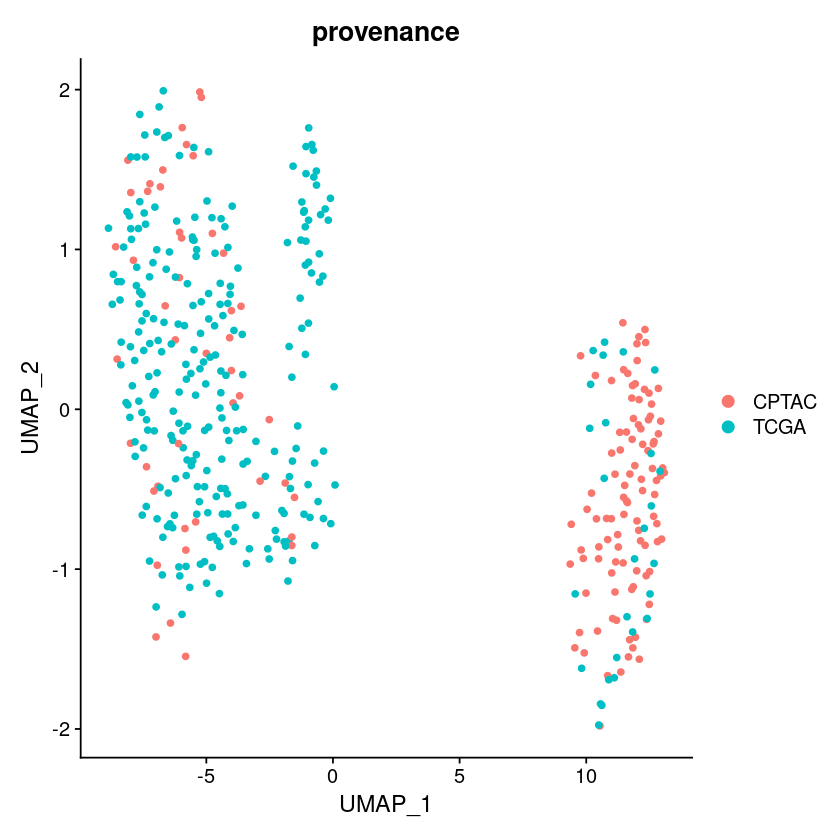

In [267]:
perform_analysis(df, 
                 bottom_n_remove = 0,
                 n_highest_var_feats = 1500,
                 pca_n_components = 30,
                 scale = T,
                 normalize = T,
                 norm_method = "LogNormalize",
                 dims_for_UMAP = 1:15,
                 plot_title = "combined_TCGA_CPTAC_pancreas",
                 color_by = "provenance",
                 regress_by_counts = T,
                 approx_svd=F,
                 seurat_clustering=F,
                 clustering_res=0.8,
                 neighbor_dims = 1:20,
                 conduct_test = F,
                 save_clustered_mutations=F)